In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.predictor import RealTimePredictor
from sagemaker.predictor import csv_serializer


*Defining Hyperparameters*

In [6]:
interval='D' # Daily
lag=20 # The time of context
horizon=10 #The time for which it can forecast
dateformat='%Y-%m-%d'
target_stock='BMW'
covariate_stocks='CON,DAI,PAH3,VOW3'
target_column='EndPrice'
covariate_columns='StartPrice,MinPrice,MaxPrice'
num_epochs=1000
batch_size=4096
dropout_ratio=0.1
percent_train=0.85

In [8]:
hyperparameters = {
    "interval": interval,
    "lag": str(lag),
    "horizon": str(horizon),
    "num_epochs": str(num_epochs),
    "batch_size": str(batch_size),
    "percent_train": str(percent_train),
#    "num_units": str(num_units),
    "target_stock": target_stock,
    "covariate_stocks": covariate_stocks,
    "target_column": target_column,
    "covariate_columns": covariate_columns,
    "dropout_ratio": str(dropout_ratio)
    
}

* TO get the stock data from s3 to notebook *

In [2]:

train_data_location='s3://sagemaker-us-west-2-886035371869/Capstone Project/KSE - 100 Index.csv'
df=pd.read_csv(train_data_location,index_col='Date')


In [ ]:
numeric_df=pd.DataFrame(index=df.index,columns=df.columns)
'''

        
''' 
numeric_df.head()

    

In [30]:
indices=[]
for x in df.index:
    x=filter(lambda x:x.isdigit() or x=='-',x)
    indices.append(x)
column_names=[]

for x in df.columns:
    x=filter(lambda x:x.isalpha(),x)
    column_names.append(x)

In [32]:
df.set

KeyError: 0

In [31]:
for index in indices:
    for column in column_names:
        x=filter(lambda x:x.isdigit(),df[index][column])
        print(x)

KeyError: '2020-07-30'

In [21]:
numeric_df.head()


,Open,High,Low,Close,Volume,MarketCap,Value
Date,,,,,,,
2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Now we are going to check if we are having any null values

In [4]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
MarketCap    0
Value        0
dtype: int64

# Now we are going to predict the closing values, so we are making Closing Values df


In [5]:
closing_values_df=df['Close'].copy()
closing_values_df.head()

Date
             2020-07-30                 39,258
             2020-07-29                 38,836
             2020-07-28                 38,627
             2020-07-27                 38,221
             2020-07-24                 37,608
Name: Close, dtype: object

* Now we have to make new df which contains only numeric values,
  currently the closing values are strings and they contain a lot of empty strings in start

In [7]:
values=[]
for x in closing_values_df.values:
    x=filter(lambda x:x.isdigit(),x)
    values.append(x)
df_values=pd.Series(values)
#df_values=df_values.astype(int)
#pd.to_numeric(df_values,downcast='float')
#df_values.reindex_like(df)
'''
plt.figure(figsize=(12,6))
df_values=df_values.astype(float)
df_values.plot(title='Closing Values',color='blue')
plt.show()
'''
df_values['Index']=closing_values_df.index
#df_values.set_index(df_values['Index'],inplace=True,drop=True)
df_values.head(-10)

0       39258
1       38836
2       38627
3       38221
4       37608
5       37578
6       37805
7       37700
8       37651
9       37331
10      37001
11      36679
12      36745
13      36619
14      36190
15      36142
16      35695
17      35373
18      35203
19      35051
20      34978
21      34889
22      34422
23      33940
24      33940
25      33710
26      34035
27      34053
28      33738
29      33439
        ...  
5400      981
5401      999
5402      956
5403      986
5404      972
5405      955
5406      931
5407      965
5408      977
5409      955
5410      981
5411      973
5412      921
5413      907
5414      884
5415      865
5416      920
5417      928
5418      983
5419      996
5420     1029
5421      959
5422      921
5423      896
5424      866
5425      884
5426      883
5427      848
5428      789
5429      766
Length: 5430, dtype: object

In [27]:
df_values=pd.to_numeric(df_values,downcast='float',errors='coerce')


In [28]:
df_values

0       39258.0
1       38836.0
2       38627.0
3       38221.0
4       37608.0
5       37578.0
6       37805.0
7       37700.0
8       37651.0
9       37331.0
10      37001.0
11      36679.0
12      36745.0
13      36619.0
14      36190.0
15      36142.0
16      35695.0
17      35373.0
18      35203.0
19      35051.0
20      34978.0
21      34889.0
22      34422.0
23      33940.0
24      33940.0
25      33710.0
26      34035.0
27      34053.0
28      33738.0
29      33439.0
         ...   
5409      955.0
5410      981.0
5411      973.0
5412      921.0
5413      907.0
5414      884.0
5415      865.0
5416      920.0
5417      928.0
5418      983.0
5419      996.0
5420     1029.0
5421      959.0
5422      921.0
5423      896.0
5424      866.0
5425      884.0
5426      883.0
5427      848.0
5428      789.0
5429      766.0
5430      775.0
5431      777.0
5432      833.0
5433      867.0
5434      886.0
5435      868.0
5436      878.0
5437      863.0
5438      880.0
Length: 5439, dtype: flo

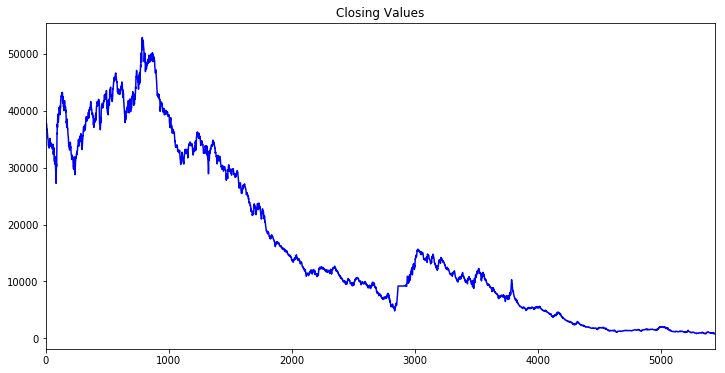

In [29]:
plt.figure(figsize=(12,6))
df_values=df_values.astype(float)
df_values.plot(title='Closing Values',color='blue')
plt.show()

In [65]:
df_values.drop(labels='Index',axis=1,inplace=True)
df_values.head()

,0
Index,
2020-07-30,39258
2020-07-29,38836
2020-07-28,38627
2020-07-27,38221
2020-07-24,37608


In [66]:
df_values.index.name='Date'
print(df_values.index.name)
df_values.head()


Date


,0
Date,
2020-07-30,39258
2020-07-29,38836
2020-07-28,38627
2020-07-27,38221
2020-07-24,37608


In [60]:
pd.to_numeric(df_values,downcast='float')

TypeError: arg must be a list, tuple, 1-d array, or Series

In [57]:
df_values.head()
df_values.squeeze(axis=1)
df_values.shape

(5439, 1)

In [67]:
df_values=df_values.astype(float)
plt.figure(figsize=(12,6))
df_values.plot(title='Closing Values',color='blue')
plt.show()

ValueError: could not convert string to float: 